In [1]:
import pandas as pd
import numpy as np
from automation_process_dataV1_5 import united_functions
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
df_ = pd.read_parquet('../../data/raw/data_model/dataset_process_trainV1.0.parquet')#Carga de datos 

In [3]:
df_processed = united_functions(df_)# Script de procesamiento de datos

In [4]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15839920 entries, 0 to 15839931
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   userId           int64  
 1   movieId          int64  
 2   rating           float64
 3   tagId            int64  
 4   relevance        float64
 5   year_rate        int32  
 6   month_rate       int32  
 7   day_rate         int32  
 8   launch_year      int32  
 9   len_title        int64  
 10  main_genre       object 
 11  secondary_genre  object 
 12  third_genre      object 
 13  valoration       object 
dtypes: float64(2), int32(4), int64(4), object(4)
memory usage: 1.5+ GB


In [5]:
# Eliminamos variables userId y movieId, ya que solo entrenaremos lo referente a items (peliculas)
def drop_userId(X):
    X.drop(['userId', 'movieId'], axis =1, inplace = True)
    return X

In [6]:
X_set=drop_userId(df_processed)

In [7]:
# Normalizamos los valores numericos
def normalizer(X):  
    # Divide el DataFrame en columnas numéricas y categóricas
    columns_numeric = X.select_dtypes(include=['int', 'float']).columns

    # normalizacion
    scaler = MinMaxScaler()
    X[columns_numeric] = scaler.fit_transform(X[columns_numeric])

    return X, scaler

In [8]:
X_set,scaler=normalizer(X_set)

In [9]:
# Codificar a numerico las variables categoricas
def categorical_encoder(X):
    # Inicializa el mapeo
    encoding_mapping = {}

    categorical_columns = ['main_genre', 'secondary_genre', 'third_genre', 'valoration']
    for column in categorical_columns:
        # Convierte la columna a tipo 'category'
        X[column] = X[column].astype('category')
        # Guarda el mapeo de la codificación
        encoding_mapping[column] = dict(enumerate(X[column].cat.categories))
        # Aplica la codificación
        X[column] = X[column].cat.codes
    
    return X, encoding_mapping

In [10]:
X_set, encoding_mapping=categorical_encoder(X_set)

Crear autoencoder V1.5

In [11]:
del df_processed
del df_

In [12]:
X_set.shape

(15839920, 12)

In [19]:
# Arquitectura autoencoder
input_size = 12
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(input_size, activation='linear')
])
full_ae = tf.keras.Sequential([encoder,decoder])

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
full_ae.compile(loss='mse', optimizer=optimizer)# optimizador y funcion de perdida

In [21]:
history = full_ae.fit(X_set, X_set, epochs=5, batch_size=64)

Epoch 1/5
247499/247499 [==============================] - 614s 2ms/step - loss: 0.0118
Epoch 2/5
247499/247499 [==============================] - 587s 2ms/step - loss: 0.0032
Epoch 3/5
247499/247499 [==============================] - 696s 3ms/step - loss: 0.0024
Epoch 4/5
247499/247499 [==============================] - 690s 3ms/step - loss: 0.0021
Epoch 5/5
247499/247499 [==============================] - 622s 3ms/step - loss: 0.0019


In [22]:
# grafico funcion perdida durante entrenamiento
def plot_model_loss (history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

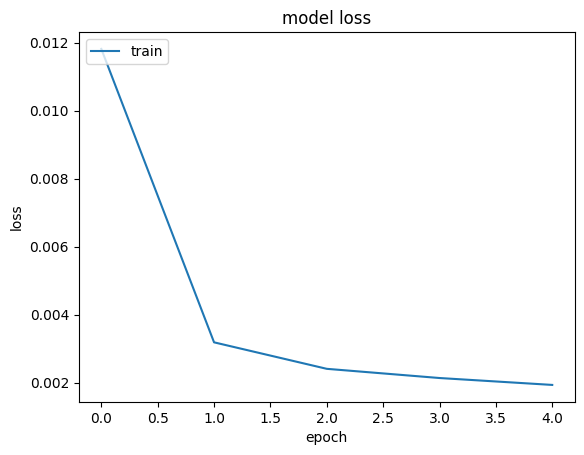

In [23]:
plot_model_loss (history)

Prediccion con conjunto de prueba

In [24]:
df_test = pd.read_parquet('../../data/raw/data_model/dataset_process_testV1.0.parquet')#Carga de datos prueba

In [25]:
df_processed_test = united_functions(df_test)# Script de procesamiento de datos

In [26]:
userId=df_processed_test.iloc[:, 0].values # Obtenemos los id correpsondientes a usuarios 
movieId=df_processed_test.iloc[:, 1] .values# Obtenemos los id correpsondientes a usuarios 
df_processed_test.drop(['userId', 'movieId'], axis =1, inplace=True)

In [27]:
# Modificamos a 0 los valores relacionados con el rating (simulando que no tenemos valoraciones para x usuarios y peliculas)
def convert_to_zero(df):
    columns_ratings=['rating', 'year_rate', 'month_rate', 'day_rate']
    df[columns_ratings] = 0
    return df

In [28]:
df_processed= convert_to_zero(df_processed_test)# Llamamos a la funcion para convertir a 0

In [29]:
X_test,scaler=normalizer(df_processed)# normalizacion
X_test, encoding_mapping=categorical_encoder(df_processed)# encoder

In [30]:
test_loss = full_ae.evaluate(X_test, X_test, batch_size=64)
print(f"Pérdida en el conjunto de prueba: {test_loss}")

61877/61877 [==============================] - 114s 2ms/step - loss: 1.0850
Pérdida en el conjunto de prueba: 1.0849509239196777


In [31]:
prediction_ = full_ae.predict(X_test)# prediccion

123753/123753 [==============================] - 201s 2ms/step


In [32]:
# transformamos en dataframe la prediccion
columns_name = X_test.columns
df_prediction = pd.DataFrame(prediction_, columns=columns_name)

In [34]:
# Desescalar numericos y aplicar valores categoricos por clave de encoding_mapping
def reconvert_types_pred(df, scaler=scaler, encoding_mapping=encoding_mapping):
    # Extraigo del df las columnas no entrenadas por el scaler
    df_scaler = df.drop(['main_genre','secondary_genre','third_genre','valoration'], axis = 1)

    # Aplicar la transformación inversa utilizando el scaler
    df[df_scaler.columns]=scaler.inverse_transform(df_scaler)
    #Convertir a enteros y float los datos correspondientes numericos
    int_values = ['tagId', 'year_rate','month_rate','day_rate','launch_year','len_title']
    df[int_values]=df[int_values].astype(int)
    df['rating']=round(df['rating'].astype(float),1)
    df['relevance']=round(df['relevance'].astype(float),2)
    
    # Sobrescribir las claves del encoding_mapping por sus valores en el DataFrame
    categorical_columns = ['main_genre', 'secondary_genre', 'third_genre', 'valoration']

    #convertir a enteros
    df[categorical_columns] = df[categorical_columns].astype(int)
    # Codificar clave/valor en mapper
    for column in categorical_columns:
        df[column] = df[column].map(encoding_mapping[column])

    return df

In [35]:
df_prediction = reconvert_types_pred(df_prediction)# llamada encoding_mapping

In [36]:
# Añadimos columnas restantes
df_prediction['userId']=userId
df_prediction['movieId']=movieId
# Movemos a primera posicion
movie=df_prediction.pop('movieId')
df_prediction.insert(0, 'movieId', movie)
# Movemos a primera posicion, reemplazando el movie
user=df_prediction.pop('userId')
df_prediction.insert(0, 'userId', user)

In [42]:
df_prediction[df_prediction['userId']==51613]

,userId,movieId,rating,tagId,relevance,year_rate,month_rate,day_rate,launch_year,len_title,main_genre,secondary_genre,third_genre,valoration
0,51613,1,0.3,1087,0.18,0,0,0,1996,12,Adventure,Animation,Animation,good
24598,51613,6,0.0,729,0.81,0,0,0,2003,6,(no genres listed),Comedy,Mystery,bad
56586,51613,21,0.0,661,-0.15,0,0,0,1998,12,Children,Comedy,Mystery,bad
64144,51613,25,0.0,805,1.04,0,0,0,1998,16,Crime,IMAX,Sci-Fi,bad
257310,51613,180,0.0,1064,-0.14,0,0,0,1999,9,Children,IMAX,Sci-Fi,bad
293594,51613,223,0.0,503,0.55,0,0,0,2000,8,Children,Sci-Fi,Thriller,bad
770468,51613,588,0.1,791,1.02,0,0,0,1997,10,Adventure,Animation,Animation,excellent
1253783,51613,1200,0.2,353,1.01,0,0,0,2000,8,Action,Adventure,Fantasy,excellent
1469767,51613,1304,0.0,664,-1.08,0,0,0,2007,31,Action,Romance,Sci-Fi,bad
1816361,51613,1923,0.0,684,0.89,0,0,0,2000,24,Children,IMAX,Sci-Fi,bad
